## Physics-informed neural networks

## Descripción desde Towards to data science

Over the last decades, artificial neural networks have been used to solve problems in varied applied domains such as computer vision, natural language processing and many more. Recently, another very promising application has emerged in the scientific machine learning (ML) community: the solution of partial differential equations (PDEs) using artificial neural networks, with an approach normally referred to as physics-informed neural networks (PINNs). PINNs have been originally introduced in the seminal work in [1] and today they are not limited anymore to a pure research topic but are gaining traction in industry as well, enough to enter the famous Gartner hype cycle for emerging technologies in 2021.

PDEs play a crucial role in many fields of engineering and fundamental science ranging from fluid dynamics to acoustic and structural engineering. Finite elements modeling (FEM) methods are the standard solvers employed ubiquitously in the industry. Despite their popularity, FEM methods display some limitations such as their computational cost for large industrial problems (mainly due to the required mesh size) and issues in leveraging external data sources, such as sensors data, to drive the solution of the PDEs.

The PINNs approach discussed in this post is regarded as a promising alternative to FEM methods for covering some of these limitations. This approach is quite different from the standard supervised ML. In fact, instead of relying purely on data, it uses the physical properties of the PDE itself to guide the training process. Known data points can be easily added on top of the physics-based loss function to speed-up training speed.

LINK: https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4

## Descripción desde el abstract del paper inicial 

We introduce physics-informed neural networks – neural networks that are trained to solve
supervised learning tasks while respecting any given laws of physics described by general
nonlinear partial differential equations. In this work, we present our developments in the
context of solving two main classes of problems: data-driven solution and data-driven
discovery of partial differential equations. Depending on the nature and arrangement of
the available data, we devise two distinct types of algorithms, namely continuous time
and discrete time models. The first type of models forms a new family of data-efficient
spatio-temporal function approximators, while the latter type allows the use of arbitrarily
accurate implicit Runge–Kutta time stepping schemes with unlimited number of stages. The
effectiveness of the proposed framework is demonstrated through a collection of classical
problems in fluids, quantum mechanics, reaction–diffusion systems, and the propagation of
nonlinear shallow-water waves.

# Descripción con textos anteriores y Gemini

## Introducción al proyecto: Redes neuronales informadas por la física (PINNs)

En los últimos años, las redes neuronales artificiales (ANNs) se han convertido en una poderosa herramienta para resolver problemas complejos en diversos dominios científicos y de ingeniería. Una aplicación particularmente prometedora es el uso de ANNs para resolver ecuaciones diferenciales parciales (EDPs), un enfoque conocido como redes neuronales informadas por la física (PINNs). Introducidas en [1], las PINNs ofrecen una alternativa convincente a los métodos tradicionales como el modelado por elementos finitos (FEM) para resolver EDPs. Si bien el FEM se usa ampliamente en la industria, puede ser computacionalmente costoso para problemas grandes y tener dificultades para incorporar fuentes de datos externas como las mediciones de sensores. Las PINNs abordan estas limitaciones al combinar el aprendizaje basado en datos con las leyes físicas rectoras encapsuladas en las EDPs mismas. Esto permite que las PINNs no solo aprendan de los datos disponibles, sino que también aprovechen la física inherente para guiar el proceso de entrenamiento. Este enfoque único tiene un gran potencial para diversos campos, que incluyen la dinámica de fluidos, la acústica, la ingeniería estructural y más.

* **Dinámica de fluidos:** Simulación de flujo de fluidos, como el flujo de aire alrededor de un ala de avión o el flujo de agua en una tubería.
* **Acústica:** Modelado de propagación de ondas sonoras, como el diseño de salas de conciertos o la reducción de ruido en motores.
* **Ingeniería estructural:** Análisis de tensiones y deformaciones en estructuras, como puentes, edificios y aviones.
* **Mecánica cuántica:** Simulación de sistemas cuánticos, como el comportamiento de átomos y moléculas.
* **Sistemas de reacción-difusión:** Modelado de reacciones químicas y difusión, como el crecimiento de cristales o la corrosión de metales.
* **Propagación de ondas de aguas poco profundas no lineales:** Simulación de olas en el océano, como olas generadas por tormentas o tsunamis.


A continuación, se implementará una PINN para resolver una EDO, en particular la de crecimiento logístico. El objetivo de esta implementación es realizar un primer acercamiento al problema y al método. El lineamiento de lo siguiente viene desde la siguiente [publicación](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4) , los comentarios y variaciones son elaboración propia.

### copypaste del post, hay que re editar esta parte según sea necesario

To keep things simple, in this post we focus on the logistic differential equation, a famous first order ordinary differential equation used to model population growth:   
$$
\frac{df(T)}{dt} = Rf(t)(1-f(t))
$$

Here the function f(t) represents the population growth rate over time t and the parameter R yields the maximum population growth rate and it strongly affects the shape of the solution. In order to fully specify the solution of this equation, one needs to impose a boundary condition, for example at t = 0 such as:

$$
f(0) = 0.5 
$$

Even though the solution to this equation can be easily derived analytically, it represents a simple playground to illustrate how PINNs work. All the techniques explained in the following are readily applicable to more complex ordinary and partial differential equations. However, for more complex scenarios additional tricks will be needed in order to get good convergence.

PINNs are based on two fundamental properties of NNs:

It has been formally demonstrated [2] that NNs are universal function approximators. Therefore a NN, provided that it is deep and expressive enough, can approximate any function and therefore also the solution for the differential equation above.
It is easy and cheap to compute the derivatives (of any order) of a NN output with respect to any of its input (and of course model parameters during backpropagation) using automatic differentiation (AD). AD is actually what made neural networks so efficient and successful in the first place.
These are nice features but how can we make the NN actually learn the solution? And here it comes the surprisingly simple but extremely clever idea behind PINNs [3, 4]: We can construct the NN loss function such that, when minimized, the PDE is automatically satisfied. In other words, the most important loss contribution is taken as the residual of the differential equation as follows:

$$
\frac{df_{NN}(T)}{dt} - Rf_{NN}(t)(1-f_{NN}(t)) = 0
$$

where $f_NN(t)$ is the output of a NN with one input and its derivative is computed using AD. It is immediate to see that if the NN output respects the equation above, one is actually solving the differential equation. To compute the actual loss contribution coming from the DE residual, one needs to specify a set of points in the equation domain (usually referred to as colocation points) and evaluate the mean square error (MSE) or another loss function as an average over all the chosen colocation points:

$$
\mathcal{L} _{DE}= \frac{1}{M} \sum_{j=1}^M\left( \frac{df_{NN}(t)}{dt}\Big|_{t_{j}} - Rf_{NN}(t_j)(1-f_{NN}(t_j) \right)^2
$$

However, a loss based only on the above residual does not ensure to have a unique solution to the equation. Therefore, let’s include the boundary condition by adding it to the loss computation in exactly the same way as above:
$$
\mathcal{L}_{BC} = (f_{NN}(t_0)-0.5)^2 \hspace{5pt} \text{con } t_0 = 0
$$

Por lo tanto, la forma final de la función de loss será:

$$
\mathcal{L} = \mathcal{L}_{DE} + \mathcal{L}_{BC}
$$

The PINN framework is very flexible and, using the ideas presented above, one can add more boundary conditions, include more complex ones such as constraints on the derivatives of f(x), or treat time-dependent and multidimensional problems using a NN with multiple inputs.

Let’s now see how to construct such loss function with a simple neural network built with PyTorch.


In [26]:
from typing import Callable
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchopt
from collections import OrderedDict
from torch.func import functional_call, grad, vmap
import scipy.io
import warnings
import plotly.graph_objects as go
warnings.filterwarnings("ignore")

torch.manual_seed(42)

In [15]:
# Implementación de PINNs para una EDO con Pytorch

class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()
    
def make_forward_fn(
    model: nn.Module,
    derivative_order: int = 1,
    ) -> list[Callable]:
        """Make a functional forward pass and gradient functions given an input model

        This function creates a set of functional calls of the input model
    
        It returns a list of composable v-mapped version of the forward pass
        and of higher-order derivatives with respect to the inputs as
        specified by the input argument `derivative_order`
    
        Args:
            model (nn.Module): the model to make the functional calls for. It can be any subclass of
                a nn.Module
            derivative_order (int, optional): Up to which order return functions for computing the
                derivative of the model with respect to the inputs
    
        Returns:
            list[Callable]: A list of functions where each element corresponds to
                a v-mapped version of the model forward pass and its derivatives. The
                0-th element is always the forward pass and, depending on the value of
                the `derivative_order` argument, the following elements corresponds to
                the i-th order derivative function with respect to the model inputs. The
                vmap ensures efficient support for batched inputs
        """
        def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter] | tuple[torch.nn.Parameter, ...]) -> torch.Tensor:
            if isinstance(params, tuple):
                params_dict = tuple_to_dict_parameters(model, params)
            else:
                params_dict = params
            return functional_call(model, params_dict, (x, ))

        fns = []
        fns.append(f)

        dfunc = f
        for _ in range(derivative_order):
            dfunc = grad(dfunc)
            dfunc_vmap = vmap(dfunc, in_dims=(0, None))
            fns.append(dfunc_vmap)
        return fns

def tuple_to_dict_parameters(
        model: nn.Module, params: tuple[torch.nn.Parameter, ...]
) -> OrderedDict[str, torch.nn.Parameter]:
    """Convert a set of parameters stored as a tuple into a dictionary form

    This conversion is required to be able to call the `functional_call` API which requires
    parameters in a dictionary form from the results of a functional optimization step which 
    returns the parameters as a tuple

    Args:
        model (nn.Module): the model to make the functional calls for. It can be any subclass of
            a nn.Module
        params (tuple[Parameter, ...]): the model parameters stored as a tuple
    
    Returns:
        An OrderedDict instance with the parameters stored as an ordered dictionary
    """
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k:v for k,v in zip(keys, values)}))

PINNs are a very active research area and much more complex and often problem-tailored neural network architectures have been devised. Discussion on these architectures is outside the scope of this introductory blog.

Build the loss function
Now that we defined our universal function approximator, let’s build the loss function. As discussed, this is composed by the DE residual term, that acts as a physics-informed regularization, and the boundary condition term, driving the network to converge to the desired solution among the infinite possible ones.

First of all, one needs to choose a set of colocation points. Since we are solving a very simple problem, we can choose a uniformly spaced grid in the time domain: t = torch.linspace(0, 1, steps=30, requires_grad=True) or we can randomly sample new colocation points from the time domain at each iteration of the optimizer. For more complex problems, the choice of colocation points is extremely important and can strongly affect the results.

For computing the model output and its derivative we are using the functional API of PyTorch which makes models fully functional by decoupling the parameters from the model itself. You can check my other post on the subject for more details.

The functional approach to PyTorch is very convenient when dealing with (higher-order) derivatives of the NN output with respect to its inputs, as often the case for PINNs. In the code below, we use the torch.func API introduced in PyTorch 2.0 to build a functional forward pass and higher-order gradient calculations with support for batches

In [7]:
from torch.func import functional_call, grad, vmap

model = LinearNN()

# notice that `functional_call` supports batched inputs by default
# thus there is not need to call vmap on it, as it's instead the case
# for the derivative calls
def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params_dict, (x, ))

# return function for computing higher order gradients with respect
# to input by simply composing `grad` calls and use again `vmap` for
# efficient batching of the input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

Notice that calls to grad can be composed without restrictions, thus allowing to compute derivatives of any order with respect to the inputs. Using the functions defined above, the MSE loss is easily computed as a sum of the DE contribution at each colocation point and the boundary contribution. Notice that, given the functional nature of the forward pass and derivatives, the loss function must also take the model params as input argument:

In [16]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value


def make_loss_fn(f: Callable, dfdx: Callable) -> Callable:
    """Make a function loss evaluation function

    The loss is computed as sum of the interior MSE loss (the differential equation residual)
    and the MSE of the loss at the boundary

    Args:
        f (Callable): The functional forward pass of the model used a universal function approximator. This
            is a function with signature (x, params) where `x` is the input data y `params` the model
            parameters
        dfdx (Callable): The functional gradient calculation of the universal function approximator. This
            is a function with signature (x, params) where `x` is the input data y `params` the model
            parameters

    Returns:
        Callable: The loss function with signature (params, x) where `x` is the input data y `params` the model
            parameters. Notice that a simple call to `dloss = functorch.grad(loss_fn)` would give the gradient
            of the loss with respecto to the model parameters needed by the optimizers
    """

    def loss_fn(params: torch.Tensor, x: torch.Tensor):
        f_value = f(x, params)
        interior = dfdx(x, params) - R * f_value * (1 - f_value)
        x0 = X_BOUNDARY
        f0 = F_BOUNDARY
        x_boundary = torch.tensor([x0])
        f_boundary = torch.tensor([f0])
        boundary = f(x_boundary, params) - f_boundary

        loss = nn.MSELoss()
        loss_value = loss(interior, torch.zeros_like(interior)) + loss(
            boundary, torch.zeros_like(boundary)
        )

        return loss_value

    return loss_fn

Iteration 0 with loss 0.6875214576721191
Iteration 1 with loss 0.07539822161197662
Iteration 2 with loss 0.061332348734140396
Iteration 3 with loss 0.06273966282606125
Iteration 4 with loss 0.060336850583553314
Iteration 5 with loss 0.06283889710903168
Iteration 6 with loss 0.061326973140239716
Iteration 7 with loss 0.05547821894288063
Iteration 8 with loss 0.056063998490571976
Iteration 9 with loss 0.046896230429410934
Iteration 10 with loss 0.034501418471336365
Iteration 11 with loss 0.023010648787021637
Iteration 12 with loss 0.013984388671815395
Iteration 13 with loss 0.040047187358140945
Iteration 14 with loss 0.01831713318824768
Iteration 15 with loss 0.011284725740551949
Iteration 16 with loss 0.022073935717344284
Iteration 17 with loss 0.029716862365603447
Iteration 18 with loss 0.0209547970443964
Iteration 19 with loss 0.015735674649477005
Iteration 20 with loss 0.013831011950969696
Iteration 21 with loss 0.006837353575974703
Iteration 22 with loss 0.013024666346609592
Iterati

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteration 147 with loss 4.898935458186315e-06
Iteration 148 with loss 3.89174829251715e-06
Iteration 149 with loss 4.0133509173756465e-06


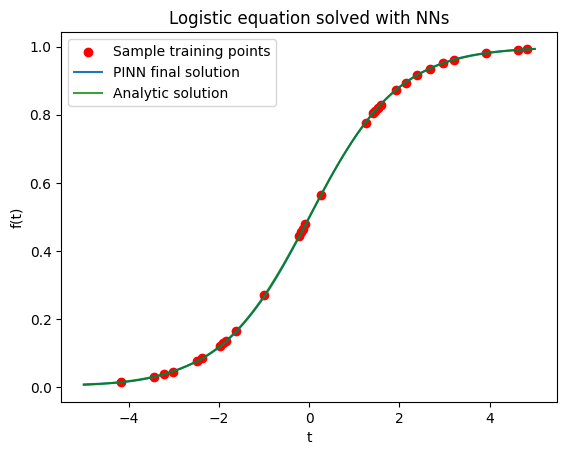

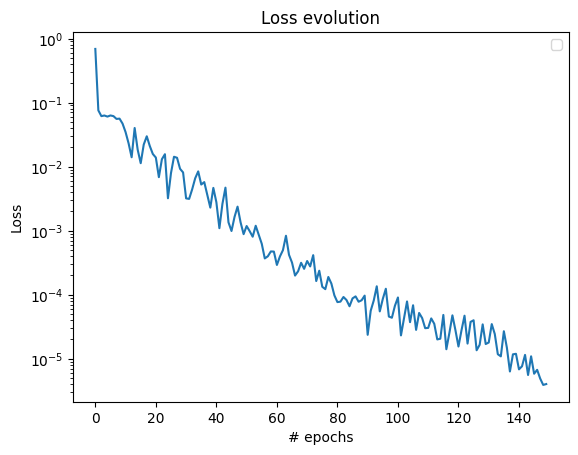

In [19]:
# Fijamos la arquitectura del MLP
num_hidden = 5
dim_hidden = 5
batch_size = 30
num_iter = 150
learning_rate = 0.1
domain = (-5.0, 5.0)

torch.manual_seed(42)

# Configuration
model = LinearNN(num_layers=num_hidden, num_neurons=dim_hidden, num_inputs=1)
funcs = make_forward_fn(model, derivative_order=1)

f = funcs[0]
dfdx = funcs[1]
loss_fn = make_loss_fn(f, dfdx)

# adam como optimizador
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# Initial parameters randomly initialized
params = tuple(model.parameters())

# Train the model
loss_evolution = []
for i in range(num_iter):
    # Sample points in the domain randomly for each epoch
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # Compute the loss with the current parameters
    loss = loss_fn(params, x)

    # Update the parameters with functional optimizer
    params = optimizer.step(loss, params)

    print(f"Iteration {i} with loss {float(loss)}")
    loss_evolution.append(float(loss))

# Plot solution on the given domain
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0/F_BOUNDARY - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(x_sample_np, analytical_sol_fn(x_sample_np), color="red", label="Sample training points")
ax.plot(x_eval_np, f_eval.detach().numpy(), label="PINN final solution")
ax.plot(
    x_eval_np,
    analytical_sol_fn(x_eval_np),
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()


That’s it! The custom loss define above ensures that after the training procedure, the NN will approximate the solution to the chosen differential equation. Now, let’s see it in action.

Solving the differential equation with PINNs
PyTorch does not currently offer native support for optimizers with the functional API we used. However, the amazing PyTorch community comes to rescue and one can get a functional version of most of PyTorch optimizers using the torchopt library. The interface of this library is very intuitive and will be immediately familiar to any PyTorch user. A basic training loop for our functional model is shown below. Notice that we sample randomly the solution domain at each iteration.

Let’s see some results. We use the Adam optimizer with a learning rate of 0.1 with 30 training points sampled uniformly from the domain at each optimization epoch. Given the simplicity of the chosen differential equation, 100 epochs are enough to almost perfectly reproduce the analytical result with a maximum growth rate set at R = 1:

Here we solved a very simple, one dimensional problem. With more complex equations, convergence is not achieved so easily. Particularly for time-dependent problems, many useful tricks have been devised over the past years such as decomposing the solution domain in different parts solved using different neural networks, smart weighting of different loss contributions to avoid converging to trivial solutions and many more. I will introduce some of these tricks in future posts, so stay tuned.

A continuación, se implementará una PINN para aproximar la ecuación de Burger. ###Comentar adecuadamente esta parte, en caso de ser útil

Link del [repositorio](https://github.com/HridayM25/Physics-Informed-NN) con el código

En lo siguiente se resolverá una EDP de la misma manera que se hizo antes, además de incluir en el código un parámetro que permita comparar para este caso el desempeño de un perceptrón multicapa normal con una PINN.

En este caso tenemos que la ecuación de Burger viene dada por:
\begin{align*}
u_t+uu_x -\frac{0.01}{\pi}u_{xx} &= 0 \hspace{5pt} \text{con } x\in[-1,1], t\in[0,1]\\
u(0,x) &= -sin(\pi x)\\
u(t,-1) &= u(t,1) = 0
\end{align*}

Ahora, sea $f := u_t+uu_t-\frac{0.01}{\pi}u_{xx}$, y con ello la función de error a minimizar es la siguiente:
\begin{align*}
MSE &= MSE_u + MSE_f\\
MSE_u &= \frac{1}{N_u} \sum_{i=1}^{N_u}|u(t_{iu},x_{iu})-u_i|^2\\
MSE_f &= \frac{1}{N_f} \sum_{i=1}^{N_f}|f(t_{if},x_{if})|^2\\
\end{align*}

El MSE_u corresponde a los datos iniciales y de borde, mientras que MSE_f impone la estructura impuesta por la ecuación de Burgers en un conjunto finito de puntos de colocación. Los puntos t, x con un subíndice u denotan los datos de entrenamiento iniciales y de límites en u(t, x) y los puntos t,x con un subíndice f especifican los puntos de colocación para f(t, x)

In [35]:
# Comenzamos cargando la data 
import scipy.io

#Cargamos la data
data = scipy.io.loadmat('burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
usol = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
train = torch.concat([torch.Tensor(X.flatten()[:, None]), torch.Tensor(T.flatten()[:, None])], 1)
X_min = train.min(0)
X_max = train.max(0)

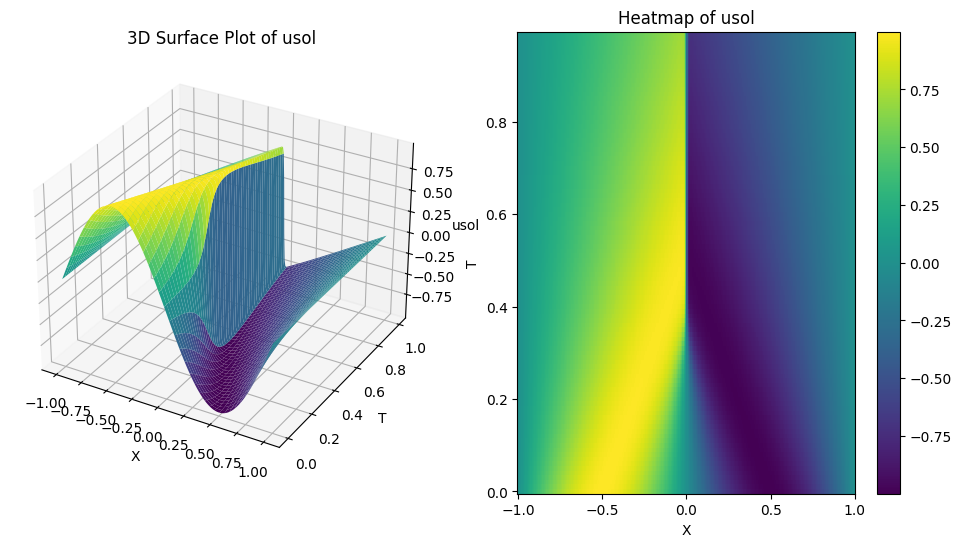

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cargamos la data
data = scipy.io.loadmat('burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
usol = np.real(data['usol']).T

# Creamos las mallas
X, T = np.meshgrid(x, t)

# Convertimos los datos para entrenamiento
train = torch.cat([torch.Tensor(X.flatten()[:, None]), torch.Tensor(T.flatten()[:, None])], 1)
X_min = train.min(0)[0]
X_max = train.max(0)[0]

# Gráfico de superficie
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, T, usol, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('usol')
ax.set_title('3D Surface Plot of usol')
#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


# Mapa de calor
ax2 = fig.add_subplot(122)
c = ax2.pcolormesh(X, T, usol, shading='auto', cmap='viridis')
ax2.set_xlabel('X')
ax2.set_ylabel('T')
ax2.set_title('Heatmap of usol')
fig.colorbar(c, ax=ax2)
plt.show()


In [37]:
#arriba podemos redefinir estas variables por el nombre que tienen, 
# o cambiarlas en el resto del código, lo dejo así momentaneamente 
# ante posibles correciones de código
X_star = train
u_star = usol
lb = X_min
ub = X_max

In [38]:
# red neuronal para u 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
#En esta implementación, se tiene que physics es un parámetro para agregar (o no)
# los residuos a la función de loss
class PINN():
    def __init__(self, X, u, lb, ub, physics):
        
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        self.physics = physics
        
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float()
        self.u = torch.tensor(u).float()
        
        self.network = Network()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.001)
        
    def makeNetwork(self, x,t):
        X = torch.cat([x,t],1)
        return self.network(X)
    
    def residual(self, x, t):
        
        u = self.makeNetwork(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),  create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u) , create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u_x) ,create_graph=True)[0]
        
        return u_t + u*u_x - (0.01/np.pi)*u_xx
    
    def lossResidual(self):
        
        u_pred = self.makeNetwork(self.x, self.t)
        residual_pred = self.residual(self.x, self.t)
        loss = torch.mean((self.u - u_pred)**2)
        if self.physics == True:   #Si physics == True agregamos la la física la loss function 
            loss += torch.mean(residual_pred**2)
        self.optimizer.zero_grad()
        loss.backward()
        return loss
    
    def train(self, epochs):
        lossTracker = []
        self.network.train()
        for idx in range(epochs):
            u_pred = self.makeNetwork(self.x, self.t)
            residual_pred = self.residual(self.x, self.t)
            loss = torch.mean((self.u - u_pred)**2)
            if self.physics == True:
                loss += torch.mean(residual_pred**2)
            #print(f"The loss at epoch {idx} is {loss.item()}")
            lossTracker.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.optimizer.step(self.lossResidual)
        return lossTracker
            
    def predict(self): 
        self.network.eval()
        u = self.makeNetwork(self.x, self.t)
        res = self.residual(self.x, self.t)
        return u.detach().numpy(), res.detach().numpy()

In [40]:
idx = np.random.choice(X_star.shape[0], 2000, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star.flatten()[:, None][idx,:]

In [41]:
model = PINN(X_u_train, u_train, lb[0], ub[0], True) #acá physics se define como True
pinn = model.train(1000)

In [42]:
model = PINN(X_u_train, u_train, lb[0], ub[0], False) #physics se define como False
no_pinn = model.train(1000)

In [49]:
epochs = list(range(len(pinn)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=pinn, mode='lines', name='Physics Informed Neural Network'))
fig.update_layout(
    title='Loss vs. Epochs PINN',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0.7, y=1.0),
    margin=dict(l=20, r=20, t=40, b=20),
    hovermode='x unified' 
)
fig.show()

In [48]:
epochs = list(range(len(pinn)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=no_pinn, mode='lines', name='Not Physics Informed Neural Network'))
fig.update_layout(
    title='Loss vs. Epochs MLP',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0.7, y=1.0),
    margin=dict(l=20, r=20, t=40, b=20),
    hovermode='x unified' 
)
fig.show()

Notamos que el error es consistentemente mayor en el primer gráfico, que corresponde a la función de de pérdida en la PINN. Con ello, tenemos entonces que en este caso para la red neuronal le es más fácil aproximar la solución sin imponer los residuos en la función de Loss.